# Import cleaned data

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [32]:
FOLDER = 'data/'
data = pd.read_csv(FOLDER+'data.csv', low_memory=False)
data.head(10)

,date,time,county_name,subject_race,officer_race,search_conducted
0,2009-10-27,11:00:00,Walla Walla County,white,white,False
1,2009-10-27,11:00:00,Franklin County,white,white,False
2,2009-10-27,11:00:00,Franklin County,white,white,False
3,2009-10-27,11:00:00,Pacific County,white,white,False
4,2009-10-27,11:00:00,King County,white,white,False
5,2009-10-27,11:00:00,King County,white,white,False
6,2009-10-27,11:00:00,King County,white,white,False
7,2009-10-27,11:00:00,King County,white,white,False
8,2009-10-27,11:00:00,King County,white,white,False
9,2009-10-27,11:00:00,King County,white,white,False


# 1. Stop proportions based on race

## 1.1 Data processing

Only keep the data needed for this part:

In [33]:
data_prop = data[['date', 'time', 'subject_race', 'officer_race']]
data_prop = data_prop.dropna()

data_prop.head(10)

,date,time,subject_race,officer_race
0,2009-10-27,11:00:00,white,white
1,2009-10-27,11:00:00,white,white
2,2009-10-27,11:00:00,white,white
3,2009-10-27,11:00:00,white,white
4,2009-10-27,11:00:00,white,white
5,2009-10-27,11:00:00,white,white
6,2009-10-27,11:00:00,white,white
7,2009-10-27,11:00:00,white,white
8,2009-10-27,11:00:00,white,white
9,2009-10-27,11:00:00,white,white


In [34]:
# Count stops for each race in races.
# df: input dataframe; stats: output dataframe
# officer: officer race; races: list of subject races
def countStops(df, stats, officer, races):
    same_race = df[(df['officer_race'] == officer) & (df['subject_race'] == officer)]
    opposite_race = df[(df['officer_race'] == officer) & (df['subject_race'] != officer)]
    count_same = same_race.shape[0]
    count_opposite = opposite_race.shape[0]
    
    temp = pd.DataFrame([[officer, officer, count_same],[officer, 'opposite', count_opposite],
                         [officer, 'all', df[df['officer_race'] == officer].shape[0]]], columns=stats.columns)
    stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    
    for race in races:
        if race!=officer:
            count = opposite_race[opposite_race['subject_race'] == race].shape[0]
            temp = pd.DataFrame([[officer, race, count]], columns=stats.columns)
            stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    
    return stats

### a) Number of stops by officer race

In [35]:
races = ['white', 'black', 'hispanic', 'asian/pacific islander', 'other']
total = data_prop.shape[0]

stats = pd.DataFrame([['all', 'all', total]], columns=['officer_race', 'subject_race', 'stop_count'])

for race in races:
    count = data_prop[data_prop['subject_race'] == race].shape[0]
    temp = pd.DataFrame([['all', race, count]], columns=stats.columns)
    stats = pd.concat([stats, temp], axis=0, ignore_index=True)
    stats = countStops(data_prop, stats, race, races)

In [36]:
# Save stats
stats.to_csv(r'data/stats.csv', index=False)

stats.head(10)

,officer_race,subject_race,stop_count
0,all,all,11294135
1,all,white,7719197
2,white,white,6627765
3,white,opposite,2659220
4,white,all,9286985
5,white,black,976277
6,white,hispanic,1159047
7,white,asian/pacific islander,366286
8,white,other,157610
9,all,black,1294744


### b) Proportion of stops by officer race

In [37]:
races.append('all')

In [38]:
totals = stats[stats['officer_race'].isin(races) & (stats['subject_race']=='all')]
stats['proportions'] = stats['stop_count']

for race in races:
    tot = totals[totals['officer_race'] == race].stop_count.to_numpy()[0]
    stats.loc[stats['officer_race'] == race, 'proportions'] = stats.loc[stats['officer_race'] == race, 'proportions'] / tot

In [39]:
stats.head(10)

,officer_race,subject_race,stop_count,proportions
0,all,all,11294135,1.000000
1,all,white,7719197,0.683470
2,white,white,6627765,0.713662
3,white,opposite,2659220,0.286338
4,white,all,9286985,1.000000
5,white,black,976277,0.105123
6,white,hispanic,1159047,0.124803
7,white,asian/pacific islander,366286,0.039441
8,white,other,157610,0.016971
9,all,black,1294744,0.114639


## 1.2 Data visualization

### a) Number of stops by officer race

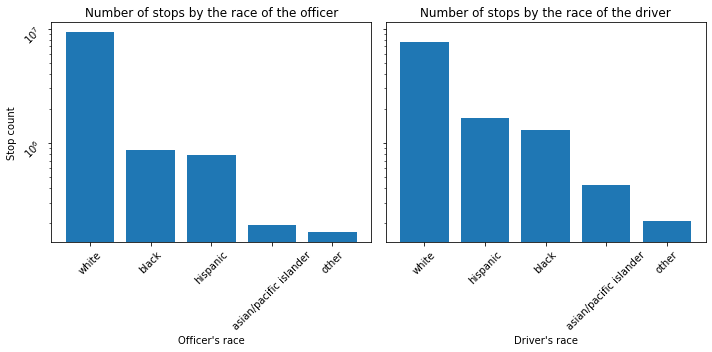

In [40]:
stats = stats.sort_values(by=['stop_count'], ignore_index=True, ascending=False)
# Plot number of stops performed by each officer race
df = stats.query("officer_race!='all' and subject_race=='all'")
# Plot number of stops on each subject_race
df2 = stats.query("officer_race=='all' and subject_race!='all'")

fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True)

axes[0].bar(df['officer_race'], df['stop_count'], log=True)
axes[1].bar(df2['subject_race'], df2['stop_count'], log=True)

# Format
axes[0].set_ylabel('Stop count')
axes[0].set_xlabel("Officer's race")
axes[0].set_title('Number of stops by the race of the officer')
axes[0].tick_params(labelrotation=45)

axes[1].set_xlabel("Driver's race")
axes[1].set_title('Number of stops by the race of the driver')
axes[1].tick_params(labelrotation=45)

fig.tight_layout()

### b) Proportion of stops by officer race

In [42]:
stats.head(10)

,officer_race,subject_race,stop_count,proportions
0,all,all,11294135,1.000000
1,white,all,9286985,1.000000
2,all,white,7719197,0.683470
3,white,white,6627765,0.713662
4,white,opposite,2659220,0.286338
5,all,hispanic,1641156,0.145310
6,all,black,1294744,0.114639
7,white,hispanic,1159047,0.124803
8,white,black,976277,0.105123
9,black,all,870472,1.000000


In [43]:
# Need a second list for the distribution plot
races_bis = ['white', 'black', 'hispanic', 'asian/pacific islander', 'other']
races_bis.reverse()

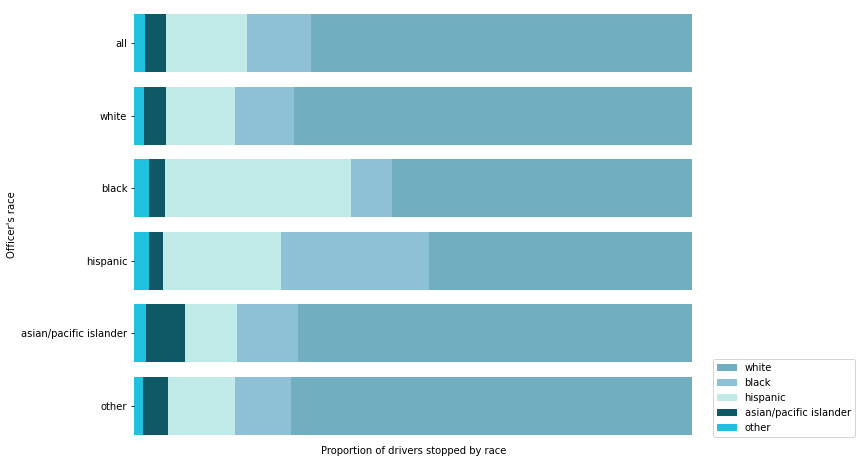

In [44]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Params for the plot aspect
codes = ['deep', 'muted', 'pastel', 'dark', 'bright']
colors = ['b', 'k', 'r', 'c', 'm', 'y']

# Compute the length of the bars for each race
for race in races:
    sums = 0
    for race_rev in races_bis:
        stats.loc[(stats['officer_race']==race) 
                  & (stats['subject_race']==race_rev), 'prop'] = stats.loc[(stats['officer_race']==race) 
                                                                           & (stats['subject_race']==race_rev), 'proportions'] + sums
        sums += stats.loc[(stats['officer_race']==race) & (stats['subject_race']==race_rev), 'proportions'].to_numpy()[0]

races.remove('all')

# Plot the barplot
for i in range(len(races)):
    sns.set_color_codes(codes[i]) # Either cycle through codes or colors to have different colors
    df = stats[stats['subject_race']==races[i]]
    sns.barplot(x="prop", y="officer_race", data=df,label=races[i], color='c')
    
    #for i, v in enumerate(dat['proportions']):
        #ax.text(dat.iloc[i,4], i-0.45, str(round(v,2)), color='blue')
    
# Add a legend and informative axis label
ax.legend(loc="lower right", frameon=True, bbox_to_anchor=(1.3, 0))
ax.set(xlim=(0, 1), ylabel="Officer's race", xlabel="Proportion of drivers stopped by race", xticks=[])
sns.despine(left=True, bottom=True)

# 2. Search rates based on race

## 2.1 Data processing

Only keep the data we need for this part:

In [45]:
data_search =  data[['date', 'time', 'county_name', 'subject_race', 'officer_race', 'search_conducted']]
data_search = data_search.dropna()

In [46]:
data_search.head(10)

,date,time,county_name,subject_race,officer_race,search_conducted
0,2009-10-27,11:00:00,Walla Walla County,white,white,False
1,2009-10-27,11:00:00,Franklin County,white,white,False
2,2009-10-27,11:00:00,Franklin County,white,white,False
3,2009-10-27,11:00:00,Pacific County,white,white,False
4,2009-10-27,11:00:00,King County,white,white,False
5,2009-10-27,11:00:00,King County,white,white,False
6,2009-10-27,11:00:00,King County,white,white,False
7,2009-10-27,11:00:00,King County,white,white,False
8,2009-10-27,11:00:00,King County,white,white,False
9,2009-10-27,11:00:00,King County,white,white,False


### a) Compute search rates by county for each subject race

In [47]:
rates = pd.DataFrame(columns=['county_name', 'subject_race', 'search_rates', 'count_searched', 'total_stops'])
group = data_search.groupby(['county_name', 'subject_race'])

for idx, df in group:
    total = df.shape[0]
    searched = df.loc[df['search_conducted']==True].shape[0]
    temp = pd.DataFrame([[idx[0], idx[1], (searched/total), searched, total]], columns=rates.columns)
    rates = pd.concat([rates, temp], axis=0, ignore_index=True)
    
rates.head(10)

,county_name,subject_race,search_rates,count_searched,total_stops
0,Adams County,asian/pacific islander,0.013936,41,2942
1,Adams County,black,0.041607,175,4206
2,Adams County,hispanic,0.029463,338,11472
3,Adams County,other,0.032220,27,838
4,Adams County,white,0.014335,1086,75756
5,Alachua County,asian/pacific islander,0.007362,6,815
6,Alachua County,black,0.033508,448,13370
7,Alachua County,hispanic,0.031549,155,4913
8,Alachua County,other,0.005386,6,1114
9,Alachua County,white,0.011561,383,33128


### b) Compute search rates for subjects of same & different race than that of the officer

In [48]:
stats_search = pd.DataFrame(columns=['county_name', 'officer_race', 'same_race_officer', 'search_rate'])
group = data_search.groupby(['county_name', 'officer_race'])

for idx, df in group:
    search_rate_same = rates.loc[(rates['county_name']==idx[0])
                                 & (rates['subject_race']==idx[1])]['search_rates'].to_numpy()[0]
    
    searched_diff = rates.loc[(rates['county_name']==idx[0]) & (rates['subject_race']!=idx[1])]['count_searched'].sum()
    searched_diff_tot = rates.loc[(rates['county_name']==idx[0]) & (rates['subject_race']!=idx[1])]['total_stops'].sum()
    if searched_diff_tot == 0:
        searched_diff = np.nan
    else:
        searched_diff = searched_diff / searched_diff_tot
    temp = pd.DataFrame([[idx[0], idx[1], True, search_rate_same],
                        [idx[0], idx[1], False, searched_diff]], columns=stats_search.columns)
    stats_search = pd.concat([stats_search, temp], axis=0, ignore_index=True)

stats_search.dropna()
stats_search.head(10)

,county_name,officer_race,same_race_officer,search_rate
0,Adams County,asian/pacific islander,True,0.013936
1,Adams County,asian/pacific islander,False,0.017622
2,Adams County,black,True,0.041607
3,Adams County,black,False,0.016394
4,Adams County,hispanic,True,0.029463
5,Adams County,hispanic,False,0.015870
6,Adams County,other,True,0.032220
7,Adams County,other,False,0.017377
8,Adams County,white,True,0.014335
9,Adams County,white,False,0.029859


### c) Data visualization

In [49]:
# Plots the scatter plot
def plotScatter(ax, df, race):
    mask= "officer_race=='"+race+"'"
    same = df.query(mask+" and same_race_officer==True")
    diff = df.query(mask+" and same_race_officer==False")
    ax.scatter(same['search_rate'] * 100, diff['search_rate'] * 100, marker='o', color='None', alpha=1, edgecolor='k', linewidth=0.5)
    
    # Add the line y=x
    lim = stats_search.query(mask)['search_rate'].max() * 100
    x = np.linspace(0,lim)
    ax.plot(x, x, ls='--', color='k', alpha=0.7)
    ax.set_xlabel(race+' officer and '+race+' driver')
    ax.set_ylabel(race+' officer and non '+race+' driver')

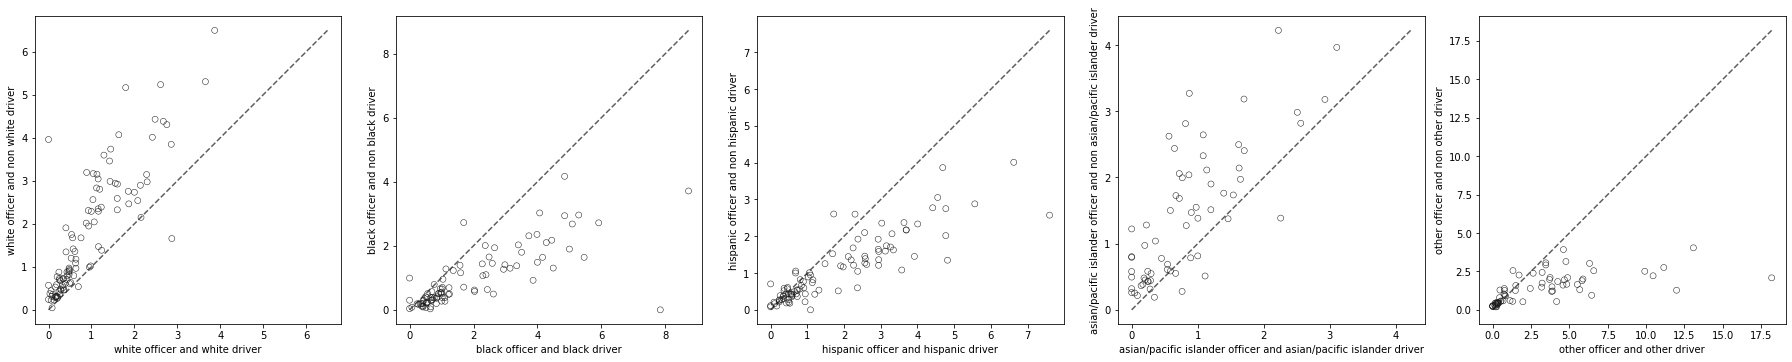

In [50]:
fig, axes = plt.subplots(1, 5, figsize=(25,5))

for i in range(len(races)):    
    plotScatter(axes[i], stats_search, races[i])
    
fig.tight_layout()